In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GATConv

In [2]:
#测试用例
edge_index = torch.tensor([[0, 1, 1, 2],
                        [1, 0, 2, 1]], dtype=torch.long)
#（竖着看）节点0与节点1有一条边连接，节点1与节点0有一条边连接，节点1与节点2有一条边连接，节点2与节点1有一条边连接【因为是无向图】
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
data#输出结果表示这个图有4条边，3个节点且特征维度是1

Data(x=[3, 1], edge_index=[2, 4])

In [3]:
dataset = Planetoid(root='./data/Cora', name='Cora')

Processing...
Done!


In [4]:
#GCN
class GCN_Net(torch.nn.Module):
    def __init__(self,features,hidden,classes):
        super(GCN_Net,self).__init__()
        self.conv1 = GCNConv(features,hidden)
        self.conv2 = GCNConv(hidden,classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN_Net(dataset.num_edge_features,16,dataset.num_classes).to(device)
data = dataset[0]
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
model.eval()
pred = model(data).argmax(dim=1)
correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7820


In [6]:
#GraphSAGE
class GraphSAGE_Net(torch.nn.Module):
    def __init__(self,features,hidden,classes):
        super(GraphSAGE_Net,self).__init__()
        self.sage1 = SAGEConv(features,hidden)
        self.sage2 = SAGEConv(hidden,classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.sage1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.sage2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE_Net(dataset.num_edge_features,16,dataset.num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    
model.eval()
_,pred = model(data).max(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct)/ int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7530


In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.nn import Node2Vec

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                context_size=10, walks_per_node=10, num_negative_samples=1,
                sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)

# 在pytorch旧版本中使用torch.optim.SparseAdam(model.parameters(), lr=0.01)，新版本中需要转为list
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z[data.train_mask], data.y[data.train_mask],z[data.test_mask], data.y[data.test_mask], max_iter=150) # 使用train_mask训练一个分类器，用test_mask分类
    return acc

In [10]:
for epoch in range(1, 101):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch:{epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch:10, Loss: 1.7319, Acc: 0.4630
Epoch:20, Loss: 0.9658, Acc: 0.6420
Epoch:30, Loss: 0.8681, Acc: 0.6870
Epoch:40, Loss: 0.8428, Acc: 0.7090
Epoch:50, Loss: 0.8325, Acc: 0.7200
Epoch:60, Loss: 0.8296, Acc: 0.7150
Epoch:70, Loss: 0.8264, Acc: 0.7060
Epoch:80, Loss: 0.8253, Acc: 0.7150
Epoch:90, Loss: 0.8246, Acc: 0.7060
Epoch:100, Loss: 0.8248, Acc: 0.7080


In [11]:

@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(data.num_nodes, device=device))
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

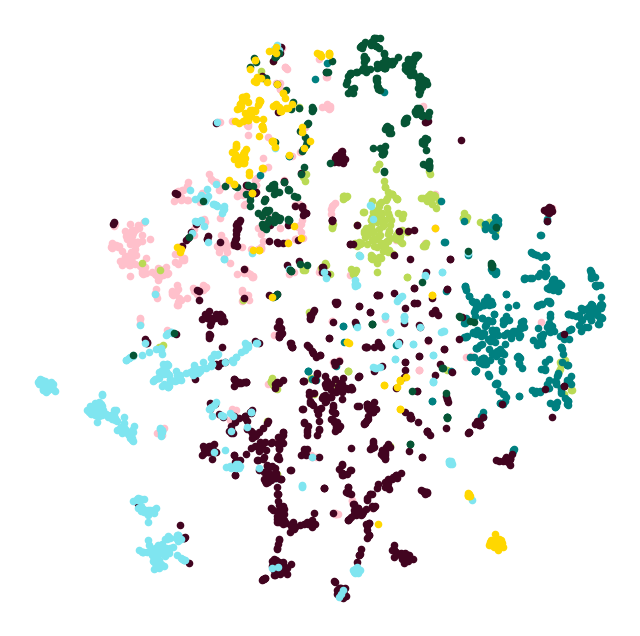

In [12]:
colors = ['#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700']
plot_points(colors)